In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape,Layer, noise
from keras.layers import Convolution1D, MaxPooling1D,Convolution2D, MaxPooling2D, Convolution3D, MaxPooling3D, LSTM, GRU
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers.wrappers import Bidirectional
from keras.layers.core import Lambda
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.utils import np_utils
from keras import backend as BK
from keras.regularizers import l1,l2,l1_l2
from sklearn import preprocessing
from keras.layers.normalization import BatchNormalization
from keras.optimizers import *
#import cv2
import IPython
from scipy.io.wavfile import read
from scipy.io.wavfile import write
from scipy.signal import spectrogram
from scipy.signal import stft
from scipy.signal import istft
from scipy import signal
from scipy.signal import firls, lfilter
import matplotlib.pyplot as plt
from numpy.lib import stride_tricks
from scipy import ndimage
import scipy.io as sio
%matplotlib inline

config = BK.tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = BK.tf.Session(config=config)
PATH='/home/user/LipReading/GRID'

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    k = np.shape(a)
    H=k[0]
    W=k[1]
    c = np.zeros((H,W))
    d = np.zeros((H,W))
    e = np.zeros((H,W))

    #Calculating mean values
    AM=np.mean(a)
    BM=np.mean(b)  

    #Calculating terms of the formula
    for ii in range(H):
      for jj in range(W):
        c[ii,jj]=(a[ii,jj]-AM)*(b[ii,jj]-BM)
        d[ii,jj]=(a[ii,jj]-AM)**2
        e[ii,jj]=(b[ii,jj]-BM)**2

    #Formula itself
    r = np.sum(c)/float(np.sqrt(np.sum(d)*np.sum(e)))
    return r

def corr2_mse_loss(a,b):
    a = BK.tf.subtract(a, BK.tf.reduce_mean(a))
    b = BK.tf.subtract(b, BK.tf.reduce_mean(b))
    tmp1 = BK.tf.reduce_sum(BK.tf.multiply(a,a))
    tmp2 = BK.tf.reduce_sum(BK.tf.multiply(b,b))
    tmp3 = BK.tf.sqrt(BK.tf.multiply(tmp1,tmp2))
    tmp4 = BK.tf.reduce_sum(BK.tf.multiply(a,b))
    r = -BK.tf.divide(tmp4,tmp3)
    m=BK.tf.reduce_mean(BK.tf.square(BK.tf.subtract(a, b)))
    rm=BK.tf.add(r,m)
    return rm

def get_activations(model, layer_in, layer_out, X_batch):
    get_activations = BK.function([model.layers[layer_in].input, BK.learning_phase()], [model.layers[layer_out].output])
    activations = get_activations([X_batch,0])
    return activations

def scheduler(epoch):
    if epoch==4:
        model.optimizer.lr.set_value(0.00001)
    return model.optimizer.lr.get_value()
change_lr=LearningRateScheduler(scheduler)

Using TensorFlow backend.


In [4]:
## Loading AutoEncoder model
autoencoder=load_model('autoencoder.h5',custom_objects={'corr2_mse_loss': corr2_mse_loss})
autoencoder.load_weights('autoencoder_weights.h5')

## Loading LipReading model
LipNet=load_model('model_LipReading.h5',custom_objects={'corr2_mse_loss': corr2_mse_loss})

#Best weights
LipNet.load_weights('Best_weights_LipReading.h5')

In [ ]:
#Train set
mat=sio.loadmat('data/preprocessed_data_part1.mat')
video_input=mat['video_input']
audio_input=mat['audio_input']
audio_output=np.reshape(audio_input,(audio_input.shape[0],audio_input.shape[1]*audio_input.shape[2]))

In [ ]:
#Test set
mat=sio.loadmat('data/preprocessed_data_face_validation.mat')
video_input=mat['video_input']
audio_input=mat['audio_input']
audio_output=np.reshape(audio_input,(audio_input.shape[0],audio_input.shape[1]*audio_input.shape[2]))

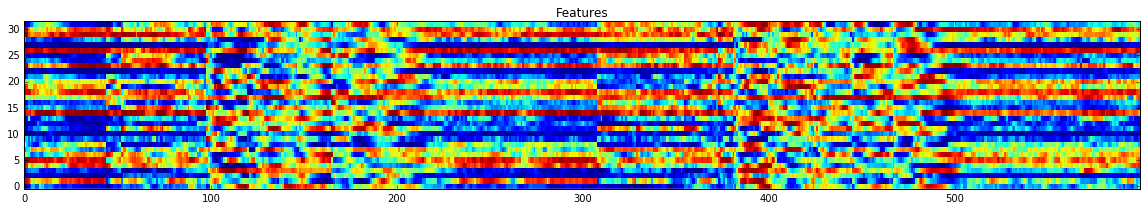

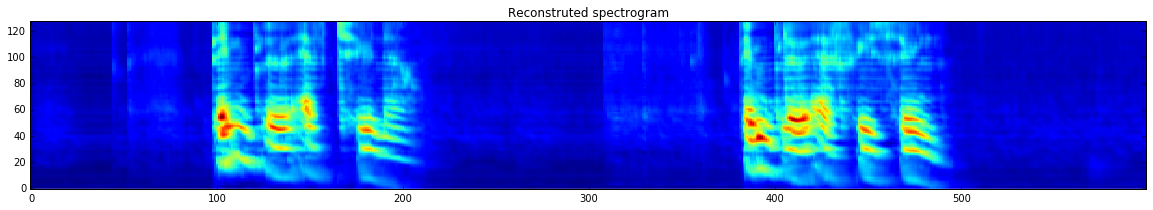

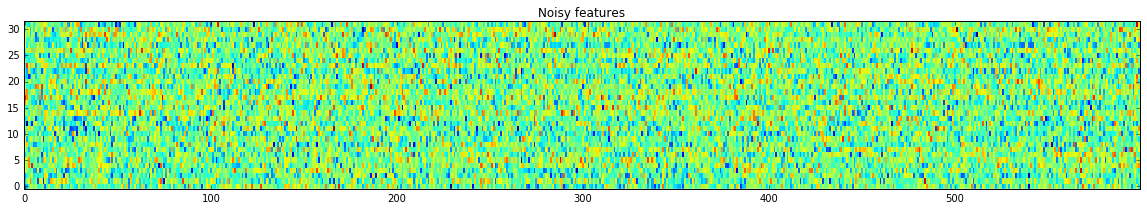

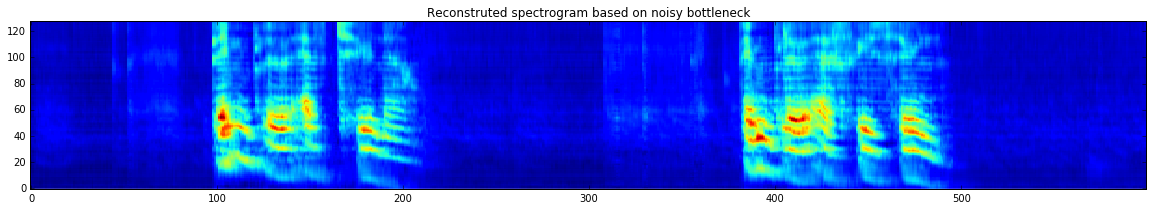

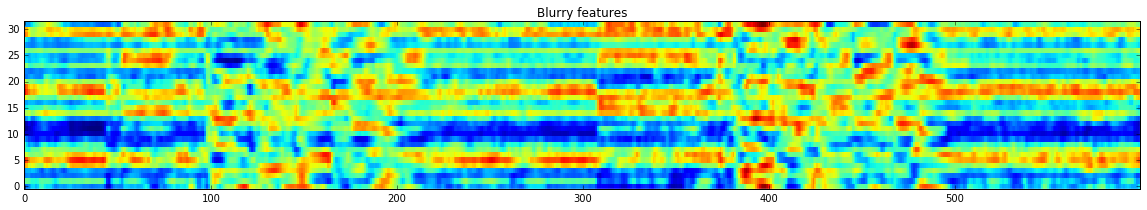

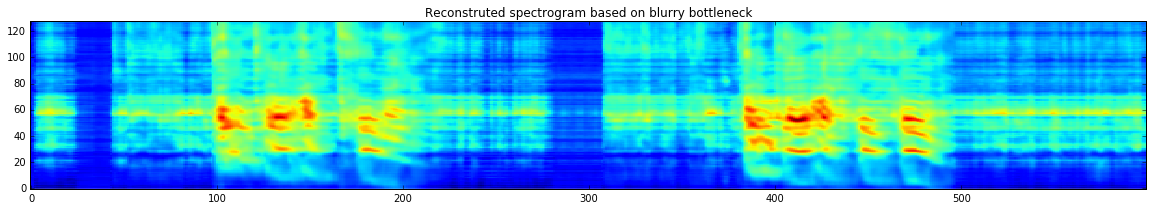

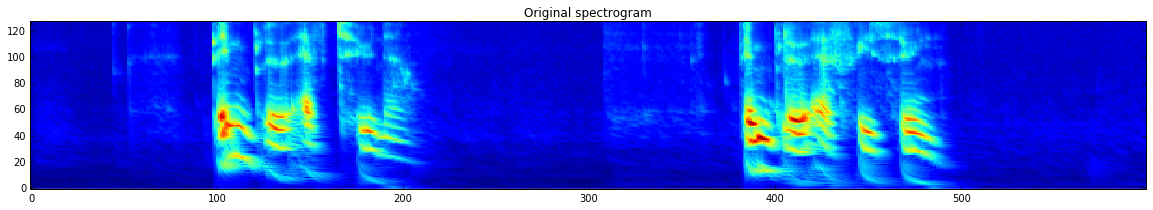

In [9]:
## Studying AutoEncoder
model1=autoencoder
f=model1.predict(audio_input[:600,:])
bottleneck=get_activations(model1, 0, 12, audio_input[:600,:])
noise_to_bottle=np.random.randn(bottleneck[0].shape[0],bottleneck[0].shape[1])
noisy=get_activations(model1, 13, 19, bottleneck[0]+.05*noise_to_bottle)
blurred_bottleneck = ndimage.gaussian_filter(bottleneck[0], sigma=.8)
blurred_recons=get_activations(model1, 13, 19, blurred_bottleneck)
sio.savemat('encoded_aud.mat', mdict={'aud': f})
sio.savemat('encoded_aud_noisy.mat', mdict={'aud': noisy[0]})
sio.savemat('encoded_aud_blurry.mat', mdict={'aud': blurred_recons[0]})
plt.figure(1,figsize=(20, 3))
plt.imshow(bottleneck[0].T, origin="lower", aspect="auto", interpolation="none")
plt.title('Features')
plt.figure(2,figsize=(20, 3))
plt.imshow(f.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstruted spectrogram')
plt.figure(3,figsize=(20, 3))
plt.imshow((bottleneck[0]+noise_to_bottle).T, origin="lower", aspect="auto", interpolation="none")
plt.title('Noisy features')
plt.figure(4,figsize=(20, 3))
plt.imshow(noisy[0].T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstruted spectrogram based on noisy bottleneck')
plt.figure(5,figsize=(20, 3))
plt.imshow(blurred_bottleneck.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Blurry features')
plt.figure(6,figsize=(20, 3))
plt.imshow(blurred_recons[0].T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstruted spectrogram based on blurry bottleneck')
plt.figure(7,figsize=(20, 3))
plt.imshow(audio_input[:600,:].T, origin="lower", aspect="auto", interpolation="none")
plt.title('Original spectrogram')

(32, 264)
(128, 264)
Min: 0.0122189
Max: 0.987458


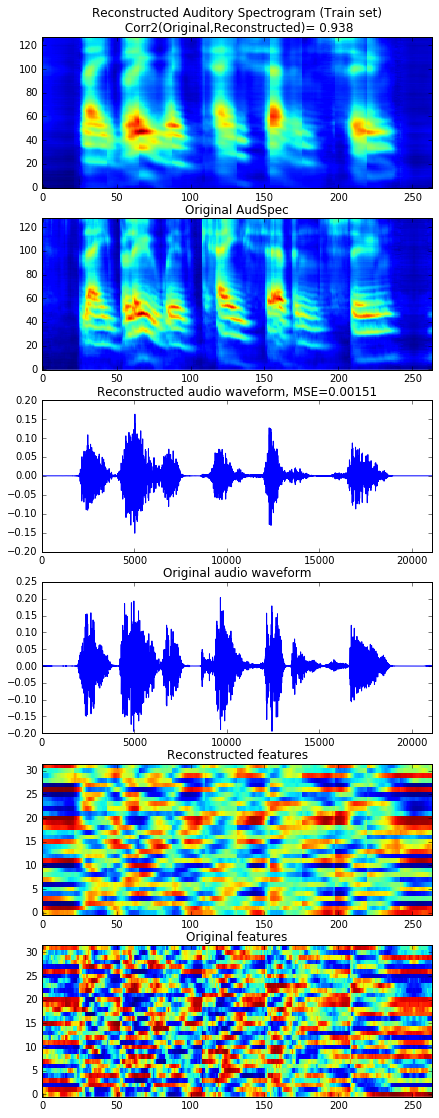

In [10]:
## Studying LipReading predictions
#Train set
#rng=range(51*14,52*14)
rng=range(51*14+2,52*14)
encode=LipNet.predict(video_input[rng,:,:,:,:])
encode=np.reshape(encode,(encode.shape[0],audio_input.shape[1],audio_input.shape[2]))
encode=np.concatenate(encode,axis=1)
encode_orig=np.concatenate(audio_input[rng,:,:],axis=1)

predicted=get_activations(autoencoder_sig, 13, 19, encode.T)[0].T
predicted_orig=get_activations(autoencoder_sig, 13, 19, encode_orig.T)[0].T
mat=sio.loadmat('Sigmoid_TRAIN.mat')
wav_lip_shuf_sig=mat['wav_lip_shuf_sig']
wav_orig_shuf_sig=mat['wav_orig_shuf_sig']
print(encode.shape)
print(predicted.shape)
print('Min: '+str(np.amin(encode)))
print('Max: '+str(np.amax(encode)))
plt.figure(1,figsize=(7, 19))
plt.subplot(6, 1, 1)
plt.imshow(predicted, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstructed Auditory Spectrogram (Train set)\n Corr2(Original,Reconstructed)= %.3f'%corr2(predicted,predicted_orig))
plt.subplot(6, 1, 2)
plt.imshow(predicted_orig, origin="lower", aspect="auto", interpolation="none")
plt.title('Original AudSpec')
sio.savemat('predicted_auto_aud_shuffled_sig_decoded_TRAIN.mat', mdict={'aud': predicted, 'aud_orig': predicted_orig})
plt.subplot(6, 1, 3)
plt.plot(wav_lip_shuf_sig)
plt.xlim((0,len(wav_lip_shuf_sig)))
#plt.ylim((-.25,.25))
plt.title('Reconstructed audio waveform, MSE=%.5f'%np.mean((wav_lip_shuf_sig-wav_orig_shuf_sig)**2))
plt.subplot(6, 1, 4)
plt.plot(wav_orig_shuf_sig)
plt.xlim((0,len(wav_lip_shuf_sig)))
#plt.ylim((-.25,.25))
plt.title('Original audio waveform')
plt.subplot(6, 1, 5)
plt.imshow(encode, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstructed features')
plt.subplot(6, 1, 6)
plt.imshow(encode_orig, origin="lower", aspect="auto", interpolation="none")
plt.title('Original features')
plt.savefig('Reconst_Aud_Feat_Train.png',format='png',dpi=1000)

(32, 308)
(128, 308)
Min: 0.00443285
Max: 0.968442


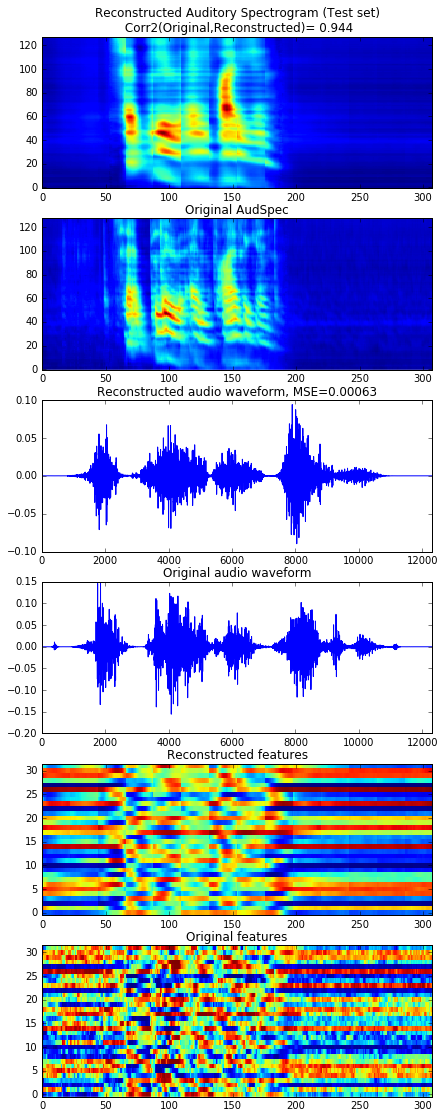

In [70]:
## Studying LipReading predictions
#Test set
#rng=range(9*14,10*14)
num=1
rng=range(num*14,(num+1)*14)
encode=LipNet.predict(video_input[rng,:,:,:,:])
encode=np.reshape(encode,(encode.shape[0],audio_input.shape[1],audio_input.shape[2]))
encode=np.concatenate(encode,axis=1)
encode_orig=np.concatenate(audio_input[rng,:,:],axis=1)

predicted=get_activations(autoencoder, 13, 19, encode.T)[0].T
predicted_orig=get_activations(autoencoder, 13, 19, encode_orig.T)[0].T
mat=sio.loadmat('Sigmoid_TEST1.mat')
wav_lip_shuf_sig=mat['wav_lip_shuf_sig_face']
wav_orig_shuf_sig=mat['wav_orig_shuf_sig_face']
print(encode.shape)
print(predicted.shape)
print('Min: '+str(np.amin(encode)))
print('Max: '+str(np.amax(encode)))
plt.figure(1,figsize=(7, 19))
plt.subplot(6, 1, 1)
plt.imshow(predicted, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstructed Auditory Spectrogram (Test set)\n Corr2(Original,Reconstructed)= %.3f'%corr2(predicted,predicted_orig))
plt.subplot(6, 1, 2)
plt.imshow(predicted_orig, origin="lower", aspect="auto", interpolation="none")
plt.title('Original AudSpec')
sio.savemat('predicted_auto_aud_shuffled_sig_decoded_TEST.mat', mdict={'aud': predicted, 'aud_orig': predicted_orig})
plt.subplot(6, 1, 3)
plt.plot(wav_lip_shuf_sig)
plt.xlim((0,len(wav_lip_shuf_sig)))
#plt.ylim((-.25,.25))
plt.title('Reconstructed audio waveform, MSE=%.5f'%np.mean((wav_lip_shuf_sig-wav_orig_shuf_sig)**2))
plt.subplot(6, 1, 4)
plt.plot(wav_orig_shuf_sig)
plt.xlim((0,len(wav_lip_shuf_sig)))
#plt.ylim((-.25,.25))
plt.title('Original audio waveform')
plt.subplot(6, 1, 5)
plt.imshow(encode, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstructed features')
plt.subplot(6, 1, 6)
plt.imshow(encode_orig, origin="lower", aspect="auto", interpolation="none")
plt.title('Original features')
#plt.savefig('Reconst_Aud_Feat_Test1.pdf',format='pdf',dpi=1000)